# ТЕМА 5. Методы машинного обучения в задачах тестирования на проникновение и поиска уязвимостей
Подготовил студент группы ББМО-01-23 Чурсинов Герман

### Требуется
1. Разработать модуль spider для получения данных с веб-приложений в формализованном виде
2. Подготовить датасет и произвести его анализ
3. Изучить возможности средства Metasploit
4. Изучить возможности средств OSINT

# 1. Разработка модуля spider для получения данных с веб-приложений в формализованном виде

Установка необходимых библиотек и создание jobs



In [1]:
!pip install scrapy
!scrapy startproject jobs
%cd jobs
!scrapy genspider example example.com
%cd jobs
%cd spiders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.8/247.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 4.1 MB/s eta 0:00:00
New Scrapy project 'jobs', using template directory '/usr/local/lib/python3.10/dist-packages/scrapy/templates/project', created in:
    /content/jobs

You can start your first spider with:
    cd jobs
    scrapy genspider example example.com
/content/jobs
Created spider 'example' using template 'basic' in module:
  jobs.spiders.example
/content/jobs/jobs
/content/jobs/jobs/spiders


Запись кода для `spider` в файл `jobs.py`

In [2]:
with open('jobs.py', 'w') as f:
    f.write("""
import scrapy

class jobs(scrapy.Spider):
    name = 'jobs'
    start_urls = ['https://pixelpeople.fandom.com/wiki/Professions']

    def parse(self, response):
        A = {}
        table = response.css('table.wikitable.sortable')[0]
        rows = table.css('tbody tr')[1:]
        for row in rows:
            cells = row.css('td')
            title = cells[0].css('::text').get().strip()
            craft_1 = cells[1].css('::text').get().strip()
            craft_2 = cells[2].css('::text').get().strip()
            A[title] = {'craft': [craft_1, craft_2]}

        yield A
""")

Запуск `spider` для извлечения данных

In [3]:
!scrapy crawl jobs -o jobs.json

2024-06-02 18:14:44 [scrapy.utils.log] INFO: Scrapy 2.11.2 started (bot: jobs)
2024-06-02 18:14:44 [scrapy.utils.log] INFO: Versions: lxml 4.9.4.0, libxml2 2.10.3, cssselect 1.2.0, parsel 1.9.1, w3lib 2.1.2, Twisted 24.3.0, Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0], pyOpenSSL 24.1.0 (OpenSSL 3.2.1 30 Jan 2024), cryptography 42.0.7, Platform Linux-6.1.85+-x86_64-with-glibc2.35
2024-06-02 18:14:44 [scrapy.addons] INFO: Enabled addons:
[]
2024-06-02 18:14:44 [asyncio] DEBUG: Using selector: EpollSelector
2024-06-02 18:14:44 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.asyncioreactor.AsyncioSelectorReactor
2024-06-02 18:14:44 [scrapy.utils.log] DEBUG: Using asyncio event loop: asyncio.unix_events._UnixSelectorEventLoop
2024-06-02 18:14:44 [scrapy.extensions.telnet] INFO: Telnet Password: ef953ca8091341a2
2024-06-02 18:14:44 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy

# 2. Подготовка датасета и его анализ

In [4]:
import pandas as pd
import json

with open('jobs.json', 'r') as file:
    data = json.load(file)

df = pd.DataFrame([{'Профессия': key, 'Элемент для крафта 1': value['craft'][0], 'Элемент для крафта 2': value['craft'][1]} for key, value in data[0].items()])

df

,Профессия,Элемент для крафта 1,Элемент для крафта 2
0,Mayor,None,None
1,Mechanic,None,None
2,Engineer,Mayor,Mechanic
3,Sheriff,Mayor,Mayor
4,Architect,Mayor,Engineer
...,...,...,...
445,Glacier,Confiseur,Jack Frost
446,Crooner,Wedding Singer,Blues Guitarist
447,Improv Drummer,Drummer,Virtuoso
448,Blues Guitarist,Guitarist,Improv Drummer


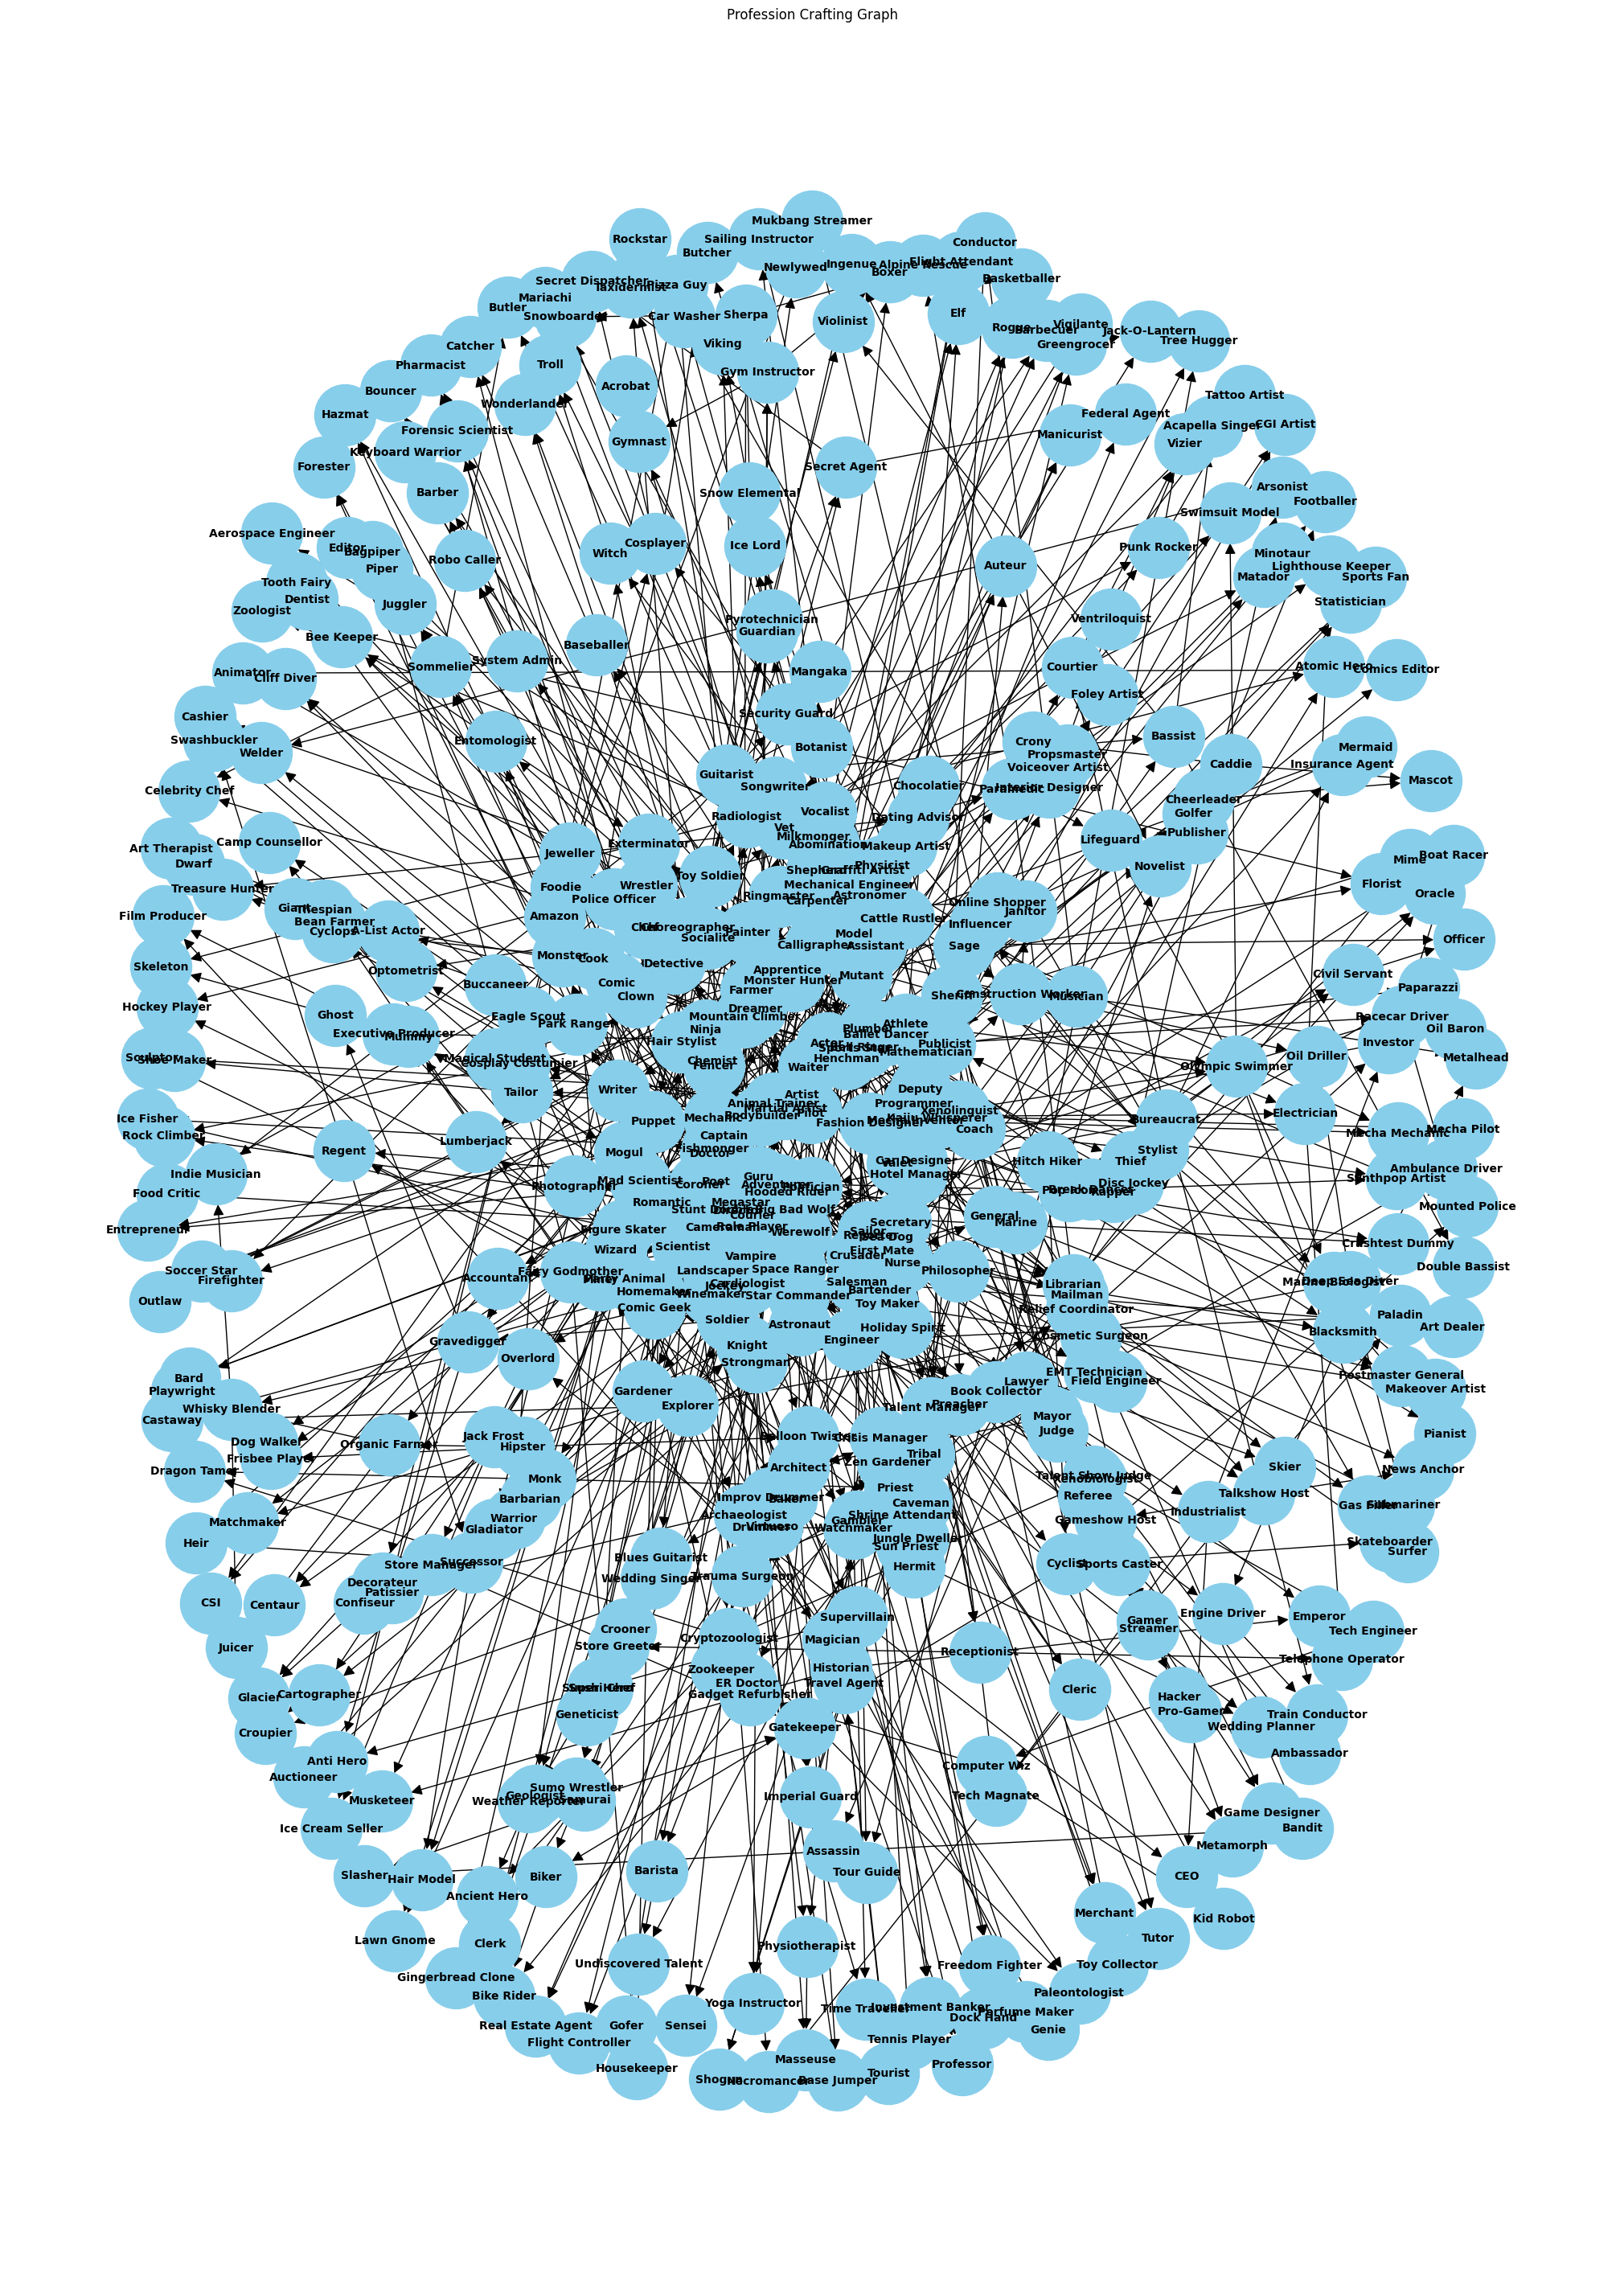

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for child, parents in data[0].items():
    G.add_node(child)
    for parent in parents['craft']:
        if parent != 'None':
            G.add_node(parent)
            G.add_edge(parent, child)

plt.figure(figsize=(20, 28))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=20)
plt.title('Profession Crafting Graph')
plt.show()

In [6]:
G = nx.DiGraph()

# Добавляем вершины и ребра в граф
for index, row in df.iterrows():
    child = row['Профессия']
    parent_1 = row['Элемент для крафта 1']
    parent_2 = row['Элемент для крафта 2']
    G.add_node(child)
    if parent_1 != 'None':
        G.add_node(parent_1)
        G.add_edge(parent_1, child)
    if parent_2 != 'None':
        G.add_node(parent_2)
        G.add_edge(parent_2, child)

# Находим стартовые вершины (вершины, из которых ничего не крафтится)
start_nodes = [node for node in G.nodes() if G.in_degree(node) == 0]

# Отрисовываем граф
plt.figure(figsize=(200, 100))
pos = nx.spring_layout(G)  # Определяем способ расположения узлов
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=20)
plt.title('Crafting Graph')
plt.show()

In [ ]:
top_parents = pd.concat([df['Элемент для крафта 1'], df['Элемент для крафта 2']]).value_counts().head(10)

# Строим график
plt.figure(figsize=(10, 6))
top_parents.plot(kind='bar', color='coral')
plt.title('Наиболее часто встречающиеся элементы в крафте')
plt.xlabel('Элемент')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Для удобной визуализации графа отрисуем его в Mermaid. Но для этого, нужно преобразовать датафрейм df в синтаксис Mermaid.

In [ ]:
mermaid_graph = 'graph TD;\n'

# Проходим по каждой строке DataFrame
for index, row in df.iterrows():
    child = row['Профессия']
    parent_1 = row['Элемент для крафта 1']
    parent_2 = row['Элемент для крафта 2']

    # Добавляем связи между родителями и ребенком
    if parent_1 != 'None':
        mermaid_graph += f'    {parent_1}-->{child};\n'
    if parent_2 != 'None':
        mermaid_graph += f'    {parent_2}-->{child};\n'

# Записываем строку в файл
with open('graph.mmd', 'w') as file:
    file.write(mermaid_graph)

Полученный код (фрагмент)

In [ ]:
graph TD
    Mayor-->Engineer;
    Mechanic --> Engineer;
    Mayor --> Sheriff;
    Mayor --> Sheriff;
    Mayor --> Architect;
    Engineer --> Architect;
    Assistant --> Landscaper;
    Architect --> Landscaper;
    Assistant --> Deputy;
    Sheriff --> Deputy;
    Landscaper --> Gardener;
    Deputy --> Gardener;
    Mechanic --> Mechanical_Engineer;
    Engineer --> Mechanical_Engineer;
    Farmer --> Botanist;
    Farmer --> Botanist;

![](https://i.imgur.com/g7PdAA1.png)

Парсинг БЕЗ помощи scrapy. Сделан с помощью bs4.

In [10]:
import requests
from bs4 import BeautifulSoup
A = {}
url = 'https://pixelpeople.fandom.com/wiki/Professions'
r = requests.get(url)
soup = BeautifulSoup(r.text, 'lxml')
a = soup.find_all('table', class_='wikitable sortable')[0].find('tbody').find_all('tr')
for _ in a[1:]:
    aaa = _.find_all('td')
    A[aaa[0].text.replace('\n', '')] = {'craft': [aaa[1].text.replace('\n', ''), aaa[2].text.replace('\n', '')]}

print(A)

{'Mayor': {'craft': ['None', 'None']}, 'Mechanic': {'craft': ['None', 'None']}, 'Engineer': {'craft': ['Mayor', 'Mechanic']}, 'Sheriff': {'craft': ['Mayor', 'Mayor']}, 'Architect': {'craft': ['Mayor', 'Engineer']}, 'Landscaper': {'craft': ['Assistant', 'Architect']}, 'Deputy': {'craft': ['Assistant', 'Sheriff']}, 'Gardener': {'craft': ['Landscaper', 'Deputy']}, 'Mechanical Engineer': {'craft': ['Mechanic', 'Engineer']}, 'Botanist': {'craft': ['Farmer', 'Farmer']}, 'Park Ranger': {'craft': ['Sheriff', 'Landscaper']}, 'Firefighter': {'craft': ['Mechanic', 'Police Officer']}, 'Farmer': {'craft': ['Engineer', 'Gardener']}, 'Doctor': {'craft': ['Engineer', 'Nurse']}, 'Nurse': {'craft': ['Homemaker', 'Gardener']}, 'Police Officer': {'craft': ['Sheriff', 'Sheriff']}, 'Vet': {'craft': ['Park Ranger', 'Doctor']}, 'Homemaker': {'craft': ['Farmer', 'Gardener']}, 'Zoologist': {'craft': ['Botanist', 'Vet']}, 'Plumber': {'craft': ['Engineer', 'Assistant']}, 'Fishmonger': {'craft': ['Farmer', 'Plumbe